## 00 configuration

In [1]:
!conda env list

# conda environments:
#
base                     /home/theekshana/anaconda3
YOLO3D                *  /home/theekshana/anaconda3/envs/YOLO3D
sr                       /home/theekshana/anaconda3/envs/sr
stereo_rcnn              /home/theekshana/anaconda3/envs/stereo_rcnn



In [2]:
import sys
# sys.path.append("../")
import importlib
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import cython
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
import torchvision
from numba import jit
from tqdm import tqdm
import time

In [3]:
from visualDet3D.data.kitti.utils import write_result_to_file
from visualDet3D.utils.utils import LossLogger, cfg_from_file
from visualDet3D.networks.utils.registry import DETECTOR_DICT, DATASET_DICT, PIPELINE_DICT
from visualDet3D.networks.heads.anchors import Anchors
from visualDet3D.networks.lib.fast_utils.hill_climbing import post_opt
from visualDet3D.networks.utils import BBox3dProjector, BackProjection
from visualDet3D.utils.utils import convertAlpha2Rot, convertRot2Alpha, draw_3D_box, compound_annotation
import visualDet3D.data.kitti.dataset
from visualDet3D.utils.timer import Timer

In [4]:
print('CUDA available: {}'.format(torch.cuda.is_available()))

cfg = cfg_from_file("config/config.py")
is_test_train = True

checkpoint_name = "Stereo3D_latest.pth"

CUDA available: True


In [5]:
# Read Conifg File
cfg.batch_size=1
split_to_test='validation'

# Define dataset_name
is_test_train = split_to_test == 'training'
if split_to_test == 'training':
    dataset_name = cfg.data.train_dataset
elif split_to_test == 'test':
    dataset_name = cfg.data.test_dataset
else:
    dataset_name = cfg.data.val_dataset

# Make dataset
dataset = DATASET_DICT[dataset_name](
        cfg, split_to_test
        )

# Split train/validation data
if split_to_test=='training':
    dataset_val = DATASET_DICT[cfg.data.val_dataset](
            cfg, 'validation'
            )
    dataset.transform = dataset_val.transform
    dataset.collate_fn = dataset_val.collate_fn


In [6]:
# Build a detector network
detector = DETECTOR_DICT[cfg.detector.name](cfg.detector)
detector = detector.cuda()

# Tensor load by GPU
weight_path = os.path.join(cfg.path.checkpoint_path, checkpoint_name)
state_dict = torch.load(weight_path, map_location='cuda:{}'.format(cfg.trainer.gpu))
new_dict = state_dict.copy()
for key in state_dict:
    if 'focalLoss' in key:
        new_dict.pop(key)

# Load the pre-trained model
detector.load_state_dict(new_dict, strict=False)
detector.eval().cuda()

# Testing pipeline
test_func = PIPELINE_DICT[cfg.trainer.test_func]

# Load projector and backprojector
projector = BBox3dProjector().cuda()
backprojector = BackProjection().cuda()

## 01 YOLO3D objext detection and bounding box estimation

In [7]:
def draw_bbox2d_to_image(image, bboxes2d, color=(255, 0, 255)):
    drawed_image = image.copy()
    for box2d in bboxes2d:
        cv2.rectangle(drawed_image, (int(box2d[0]), int(box2d[1])), (int(box2d[2]), int(box2d[3])), color, 3)
    return drawed_image

In [8]:
index = 0
def corner_homo2bbox(corner_homo):
    """
        corner_homo: [N, 8, 3]
    """
    min_xy  = torch.min(corner_homo[:, :, 0:2], dim=1)[0]
    max_xy  = torch.max(corner_homo[:, :, 0:2], dim=1)[0]
    min_xy[:, 0]  = torch.clamp(min_xy[:, 0], 0, cfg.rgb_shape[1])
    min_xy[:, 1]  = torch.clamp(min_xy[:, 1], 0, cfg.rgb_shape[0])
    max_xy[:, 0]  = torch.clamp(max_xy[:, 0], 0, cfg.rgb_shape[1])
    max_xy[:, 1]  = torch.clamp(max_xy[:, 1], 0, cfg.rgb_shape[0])
    return torch.cat([min_xy, max_xy], dim=1)

def denorm(image):
    new_image = np.array((image * cfg.data.augmentation.rgb_std +  cfg.data.augmentation.rgb_mean) * 255, dtype=np.uint8)
    return new_image

@jit(cache=True, nopython=True)
def ToColorDepth(depth_image:np.ndarray)->np.ndarray: #[H, W] -> [H, W, 3] # Used to draw depth predictions
    H, W = depth_image.shape
    max_depth = float(np.max(depth_image))
    cmap = np.array([
        [0,0,0,114],[0,0,1,185],[1,0,0,114],[1,0,1,174], 
        [0,1,0,114],[0,1,1,185],[1,1,0,114],[1,1,1,0]
    ])
    _sum  = 0
    for i in range(8):
        _sum += cmap[i, 3]
    
    weights = np.zeros(8)
    cumsum = np.zeros(8)
    for i in range(7):
        weights[i] = _sum / cmap[i, 3]
        cumsum[i+1] = cumsum[i] + cmap[i, 3] / _sum
    
    image = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(H):
        for j in range(W):
            val = depth_image[i, j] / max_depth
            for k in range(7):
                if val <= cumsum[k + 1]:
                    break
            w = 1.0- (val - cumsum[k]) * weights[k]
            r = int( (w * cmap[k, 0] + (1 - w) * cmap[k+1, 0]) * 255 )
            g = int( (w * cmap[k, 1] + (1 - w) * cmap[k+1, 1]) * 255 )
            b = int( (w * cmap[k, 2] + (1 - w) * cmap[k+1, 2]) * 255 )
            image[i, j] = np.array([r,g,b])
    return image

In [9]:
def compute_once(index, is_draw=True, is_test_train=True):
    name = "%06d" % index
#     print(name)
    data = dataset[index]
    if isinstance(data['calib'], list):
        P2 = data['calib'][0]
    else:
        P2 = data['calib']
    original_height = data['original_shape'][0]
    collated_data = dataset.collate_fn([data])
    height = collated_data[0].shape[2]
    scale_2d = (original_height - cfg.data.augmentation.crop_top) / height
    
    if len(collated_data) > 6:
        left_images, right_images, _, _, labels, bbox_3d, _ = collated_data
    else:
        left_images, right_images, _, _, labels, bbox_3d = collated_data
    image = left_images

    with torch.no_grad():
        
        left_images, right_images, P2, P3 = collated_data[0], collated_data[1], collated_data[2], collated_data[3]
        scores, bbox, obj_names = detector([left_images.cuda().float().contiguous(),
                                          right_images.cuda().float().contiguous(),
                                          P2.cuda().float(),
                                          P3.cuda().float()])
        
        P2 = P2[0]
        bbox_2d = bbox[:, 0:4]
        bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
        bbox_3d_state_3d = backprojector(bbox_3d_state, P2.cuda()) #[x, y, z, w,h ,l, alpha]
        abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state_3d, P2.cuda())

            
    
    rgb_image = denorm(image[0].cpu().numpy().transpose([1, 2, 0]))
    if len(scores) > 0:
        rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d.cpu().numpy())
        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)
    if is_draw:
        plt.imshow(np.clip(rgb_image, 0, 255))
        plt.show()

    return np.clip(rgb_image, 0, 255)

In [10]:
def compute_once_3d_bounding_box_only(index, is_draw=True, is_test_train=True):
    name = "%06d" % index
#     print(name)
    data = dataset[index]
    if isinstance(data['calib'], list):
        P2 = data['calib'][0]
    else:
        P2 = data['calib']
    original_height = data['original_shape'][0]
    collated_data = dataset.collate_fn([data])
    height = collated_data[0].shape[2]
    scale_2d = (original_height - cfg.data.augmentation.crop_top) / height
    
    if len(collated_data) > 6:
        left_images, right_images, _, _, labels, bbox_3d, _ = collated_data
    else:
        left_images, right_images, _, _, labels, bbox_3d = collated_data
    image = left_images

    with torch.no_grad():
        
        left_images, right_images, P2, P3 = collated_data[0], collated_data[1], collated_data[2], collated_data[3]
        scores, bbox, obj_names = detector([left_images.cuda().float().contiguous(),
                                          right_images.cuda().float().contiguous(),
                                          P2.cuda().float(),
                                          P3.cuda().float()])
        
        P2 = P2[0]
        bbox_2d = bbox[:, 0:4]
        bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
        bbox_3d_state_3d = backprojector(bbox_3d_state, P2.cuda()) #[x, y, z, w,h ,l, alpha]
        abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state_3d, P2.cuda())

            
    
    rgb_image = denorm(image[0].cpu().numpy().transpose([1, 2, 0]))
    if len(scores) > 0:
        
        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)
    if is_draw:
        plt.imshow(np.clip(rgb_image, 0, 255))
        

    return np.clip(rgb_image, 0, 255)

In [11]:
def show_3d_boxes(index):
    fig = plt.figure(figsize=(16,9))
    a = compute_once_3d_bounding_box_only(index, is_test_train=False, is_draw=True)

### 2D + 3D bounding boxes

/home/theekshana/Documents/visualDet3D/visualDet3D/data/kitti/dataset/stereo_dataset.py:155: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525553989/work/torch/csrc/utils/tensor_new.cpp:230.)
  return torch.from_numpy(left_images).float(), torch.from_numpy(right_images).float(), torch.tensor(P2).float(), torch.tensor(P3).float(), label, bbox2ds, bbox3ds
/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


PSM Cos Volume takes 0.008785247802734375 seconds at call time 1


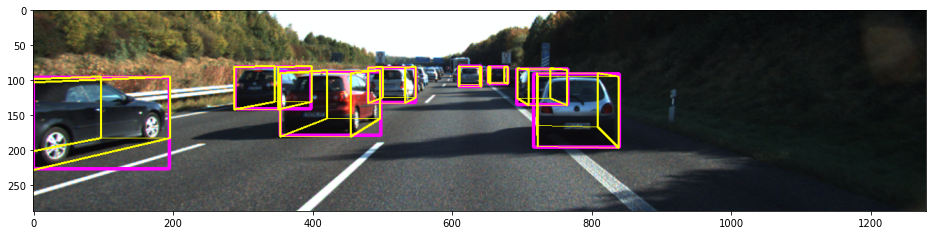

In [12]:
#%matplotlib inline
fig = plt.figure(figsize=(16,9))
index = 2
a = compute_once(index, is_test_train=False, is_draw=True)
# print(index,cv2.imwrite(('data/2d3d %02d.png'%index), cv2.cvtColor(a, cv2.COLOR_RGB2BGR)))

### 3D bounding boxes Only

/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


PSM Cos Volume takes 0.01867842674255371 seconds at call time 2
PSM Cos Volume takes 0.009032249450683594 seconds at call time 3
Cost Volume takes 0.007516145706176758 seconds at call time 1


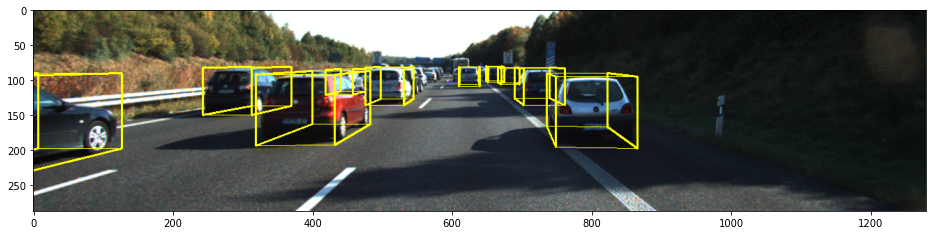

In [13]:
show_3d_boxes(10)

## 02 Tracking

In [13]:
from IPython.display import clear_output

In [15]:
pwd

'/home/theekshana/Documents/visualDet3D'

In [14]:
def get_predictions(index):
    name = "%06d" % index
    data = dataset[index]
    if isinstance(data['calib'], list):
        P2 = data['calib'][0]
    else:
        P2 = data['calib']
    original_height = data['original_shape'][0]
    collated_data = dataset.collate_fn([data])
    height = collated_data[0].shape[2]
    scale_2d = (original_height - cfg.data.augmentation.crop_top) / height
    
    if len(collated_data) > 6:
        left_images, right_images, _, _, labels, bbox_3d, _ = collated_data
    else:
        left_images, right_images, _, _, labels, bbox_3d = collated_data
    image = left_images

    with torch.no_grad():
        
        left_images, right_images, P2, P3 = collated_data[0], collated_data[1], collated_data[2], collated_data[3]
        scores, bbox, obj_names = detector([left_images.cuda().float().contiguous(),
                                          right_images.cuda().float().contiguous(),
                                          P2.cuda().float(),
                                          P3.cuda().float()])
        
        P2 = P2[0]
        bbox_2d = bbox[:, 0:4]
        bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
        bbox_3d_state_3d = backprojector(bbox_3d_state, P2.cuda()) #[x, y, z, w,h ,l, alpha]
        abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state_3d, P2.cuda())
        
        rgb_image = denorm(image[0].cpu().numpy().transpose([1, 2, 0]))
        
        return rgb_image, scores, bbox_2d, obj_names, bbox_3d_corner_homo
    
#     if len(scores) > 0:
#         rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d.cpu().numpy())
#         for box in bbox_3d_corner_homo:
#             box = box.cpu().numpy().T
#             rgb_image = draw_3D_box(rgb_image, box)
#     if is_draw:
#         plt.imshow(np.clip(rgb_image, 0, 255))
        
#     return np.clip(rgb_image, 0, 255)

In [15]:
from sort import *
#create instance of SORT
mot_tracker = Sort() 

In [16]:
def assignTrackID(index):
    # get detections
    rgb_image, scores, bbox_2d, obj_names, bbox_3d_corner_homo=get_predictions(index)
    
    if len(scores) > 0:
        
        detectionsList=[]
        for i in range(len(scores)):
            detection=np.append((bbox_2d[i]).cpu(),scores[i].cpu())
            detectionsList.append(detection)
        detectionsNumPyArray = np.asarray(detectionsList)
        # update SORT
        #  def update(self, dets=np.empty((0, 5))):
        """
            Params:
              dets - a numpy array of detections in the format [[x1,y1,x2,y2,score],[x1,y1,x2,y2,score],...]
            Requires: this method must be called once for each frame even with empty detections (use np.empty((0, 5)) for frames without detections).
            Returns the a similar array, where the last column is the object ID.

            NOTE: The number of objects returned may differ from the number of detections provided.
        """
        track_bbs_ids = mot_tracker.update(detectionsNumPyArray)
    # track_bbs_ids is a np array where each row contains a valid bounding box and track_id (last column)

        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)

        track_bbs_ids_list=track_bbs_ids.tolist()
        
        for j in range(len(track_bbs_ids_list)):
            coords = track_bbs_ids_list[j]
            x1,y1,x2,y2=int(coords[0]),int(coords[1]),int(coords[2]),int(coords[3])
            trackID=int(coords[4])
            name="ID: {}".format(str(trackID))

            # font
            font = cv2.FONT_HERSHEY_SIMPLEX
            # org
            org = (x1, y1-10)
            # fontScale
            fontScale = 0.9
            # Line thickness of 2 px
            thickness = 3
            # Blue color in BGR
            color=(0, 255, 255)
            text_color_bg=(0, 0, 0)
            text_size, _ = cv2.getTextSize(name, font, fontScale, thickness)
            text_w, text_h = text_size
            cv2.rectangle(rgb_image, (x1 , y1-10 - text_h), (x1 + text_w, y1-10), text_color_bg, -1)
            
            # Using cv2.putText() method
            cv2.putText(rgb_image,name, org, font, fontScale, color, thickness, cv2.LINE_AA)

                
# def draw_bbox2d_to_image(image, bboxes2d, color=(255, 0, 255)):
#     drawed_image = image.copy()
#     for box2d in bboxes2d:
#         cv2.rectangle(drawed_image, (int(box2d[0]), int(box2d[1])), (int(box2d[2]), int(box2d[3])), color, 3)
#     return drawed_image
            
    return np.clip(rgb_image, 0, 255)

### 3D bounding boxes + Track ID

/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


PSM Cos Volume takes 0.018428564071655273 seconds at call time 2
PSM Cos Volume takes 0.008975505828857422 seconds at call time 3
Cost Volume takes 0.00739288330078125 seconds at call time 1
Time taken : 2.3905327320098877 seconds
Estimated frames per second : 0.418316798849782


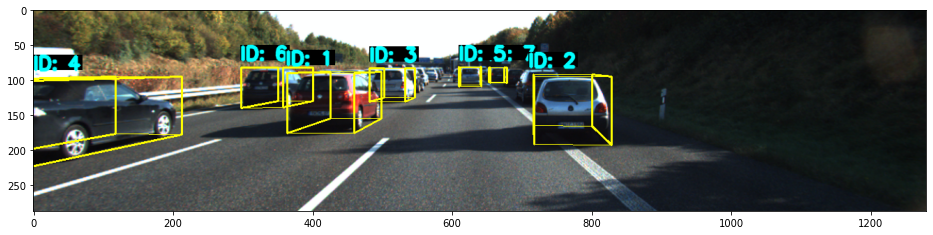

In [17]:
fig = plt.figure(figsize=(16,9))
index=0

start = time.time()
a=assignTrackID(index)
end = time.time()

plt.imshow(a)
plt.show()
# Time elapsed
seconds = end - start
print ("Time taken : {0} seconds".format(seconds))

# Calculate frames per second
fps  = 1 / seconds
print("Estimated frames per second : {0}".format(fps))

## 02 Trajectory Prediction

## 03 saving results

In [ ]:
import time

def get_frame_rate():
    # Start time
    start = time.time()

    # Grab a few frames
    for i in range(0, num_frames) :
        ret, frame = video.read()

    # End time
    end = time.time()

    # Time elapsed
    seconds = end - start
    print ("Time taken : {0} seconds".format(seconds))

    # Calculate frames per second
    fps  = num_frames / seconds
    print("Estimated frames per second : {0}".format(fps))

### 2D + 3D bounding boxes

In [30]:
start_2d3d = time.time()

for index in range(0,837):
#     fig = plt.figure(figsize=(16,9))
    a = compute_once(index, is_test_train=False, is_draw=False)
#     clear_output(wait=True)
#     plt.imshow(a)
    print(index,cv2.imwrite(('data/2d3d %03d.png'%index), cv2.cvtColor(a, cv2.COLOR_RGB2BGR)))
#     plt.xlabel(index)
#     plt.show()
         
end_2d3d = time.time()
# Time elapsed
seconds_2d3d  = end_2d3d  - start_2d3d 
print ("Time taken : {0} seconds".format(seconds_2d3d))

# Calculate frames per second
fps_2d3d  = 837 / seconds_2d3d
print("Estimated frames per second : {0}".format(fps_2d3d))

/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
13 True
14 True
15 True
16 True
17 True
18 True
19 True
20 True
21 True
22 True
23 True
24 True
25 True
26 True
27 True
28 True
29 True
30 True
31 True
32 True
33 True
34 True
35 True
36 True
37 True
38 True
39 True
40 True
41 True
42 True
43 True
44 True
45 True
46 True
47 True
48 True
49 True
50 True
51 True
52 True
53 True
54 True
55 True
56 True
57 True
58 True
59 True
60 True
61 True
62 True
63 True
64 True
65 True
66 True
67 True
68 True
69 True
70 True
71 True
72 True
73 True
74 True
75 True
76 True
77 True
78 True
79 True
80 True
81 True
82 True
83 True
84 True
85 True
86 True
87 True
88 True
89 True
90 True
91 True
92 True
93 True
94 True
95 True
96 True
97 True
98 True
99 True
100 True
101 True
102 True
103 True
104 True
105 True
106 True
107 True
108 True
109 True
110 True
111 True
112 True
113 True
114 True
115 True
116 True
117 True
118 True
119 True
120 True
121 True
122 True
123

NameError: name 'seconds' is not defined

### 3D bounding boxes Only

In [32]:
start_3d = time.time()
for index in range(0,837):
#     fig = plt.figure(figsize=(16,9))
    a = compute_once_3d_bounding_box_only(index, is_test_train=False, is_draw=False)
#     clear_output(wait=True)
#     plt.imshow(a)
    print(index,cv2.imwrite(('data/3d %03d.png'%index), cv2.cvtColor(a, cv2.COLOR_RGB2BGR)))
#     plt.xlabel(index)
#     plt.show()
         
end_3d = time.time()
# Time elapsed
seconds_3d = end_3d - start_3d
print ("Time taken : {0} seconds".format(seconds_3d))

# Calculate frames per second
fps_3d  = 837 / seconds_3d
print("Estimated frames per second : {0}".format(fps_3d))

/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
13 True
14 True
15 True
16 True
17 True
18 True
19 True
20 True
21 True
22 True
23 True
24 True
25 True
26 True
27 True
28 True
29 True
30 True
31 True
32 True
33 True
34 True
35 True
36 True
37 True
38 True
39 True
40 True
41 True
42 True
43 True
44 True
45 True
46 True
47 True
48 True
49 True
50 True
51 True
52 True
53 True
54 True
55 True
56 True
57 True
58 True
59 True
60 True
61 True
62 True
63 True
64 True
65 True
66 True
67 True
68 True
69 True
70 True
71 True
72 True
73 True
74 True
75 True
76 True
77 True
78 True
79 True
80 True
81 True
82 True
83 True
84 True
85 True
86 True
87 True
88 True
89 True
90 True
91 True
92 True
93 True
94 True
95 True
96 True
97 True
98 True
99 True
100 True
101 True
102 True
103 True
104 True
105 True
106 True
107 True
108 True
109 True
110 True
111 True
112 True
113 True
114 True
115 True
116 True
117 True
118 True
119 True
120 True
121 True
122 True
123

In [33]:
print(start_3d)
print(end_3d)
print(seconds_3d)
print(fps_3d)

1680770171.802954
1680771943.199522
1771.3965680599213
0.4725085365366287


### 3D bounding boxes + Track ID

In [21]:
start_track = time.time()

for index in range(0,5):
    fig = plt.figure(figsize=(16,9))
    a = assignTrackID(index)
    clear_output(wait=True)
    plt.imshow(a)
    plt.xlabel(index)
    plt.show()
#     print(index,cv2.imwrite(('data/track %03d.png'%index), cv2.cvtColor(a, cv2.COLOR_RGB2BGR)))
end_track = time.time()


# Time elapsed
seconds_track = end_track - start_track
print ("Time taken : {0} seconds".format(seconds_track))

# Calculate frames per second
fps_track  = 837 / seconds_track
print("Estimated frames per second : {0}".format(fps_track))

Time taken : 47.59913086891174 seconds
Estimated frames per second : 17.584354687170705


In [ ]:
print(start_track)
print(end_track)
print(seconds_track)
print(fps_track)